In [1]:
import keras
import tensorflow as tf
from keras import layers,Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical,normalize
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,TensorBoard
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm_notebook as tqdm
import warnings
import keras.backend as K
import random
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#Loading already preprocessed files.
x_test=joblib.load('x_test.pkl')
x_train=joblib.load('x_train.pkl')
y_test=joblib.load('y_test.pkl')
y_train=joblib.load('y_train.pkl')
y_cv=joblib.load('y_cv.pkl')
x_cv=joblib.load('x_cv.pkl')

In [3]:
print("Shape of Train data {}".format(x_train.shape))
print("Shape of Cv data {}".format(x_cv.shape))
print("Shape of Test data {}".format(x_test.shape))

Shape of Train data (7676, 299, 299, 3)
Shape of Cv data (505, 299, 299, 3)
Shape of Test data (2020, 299, 299, 3)


In [4]:
Y_train=to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_cv = to_categorical(y_cv)

### Xception Network

In [5]:
#Greedy Layer-Wise Pretraining Learned from : https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/
# 1. Pre-training the network with train data on initilizing the "imagenet" weights with "include_top=False"
# 2. After training 3 epochs remove the top most layer
# 3. Now add similar top layer and again train and validate


Xception_initial=Xception(include_top=False,
                 weights='imagenet',
                 input_shape=(299,299,3),pooling ='avg',
                 )
#print(Xception_pre_trained.summary())

for layer in Xception_initial.layers:
    layer.trainable = True

x = Xception_initial.output
predicted = Dense(2,activation ='softmax')(x)
model_pretrain = Model(input = Xception_initial.input, output = predicted)
model_pretrain.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(lr = 0.0002),
          metrics=['accuracy'])
pretraining_Xception =model_pretrain.fit(x_train, Y_train,
                                              verbose=1,
                                              batch_size=32,  
                                              epochs=3)

Epoch 1/3
7676/7676 [==============================] - 5085s 663ms/step - loss: 0.0372 - accuracy: 0.9855
Epoch 2/3
7676/7676 [==============================] - 4999s 651ms/step - loss: 0.0044 - accuracy: 0.9990
Epoch 3/3
7676/7676 [==============================] - 5008s 652ms/step - loss: 0.0026 - accuracy: 0.9991


In [6]:
model_pretrain.layers.pop() # Removing topmost layer

In [7]:
tensorboard=TensorBoard(log_dir='./logs', histogram_freq=3)

In [8]:

for layer in model_pretrain.layers:
    layer.trainable = False
x = model_pretrain.output
#x= Dense(64,activation ='relu')(x)
#x = Dropout(0.2)(x)
#x= Dense(64,activation ='relu')(x)
#x = Dropout(0.2)(x)
#x= BatchNormalization()(x) 
predicted = Dense(2,activation ='softmax')(x)
model_finetune1 = Model(input = model_pretrain.input, output = predicted)
model_finetune1.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adam(lr = 0.0002),
          metrics=['accuracy'])

finetuning1_XceptionNet=model_finetune1.fit(x_train, Y_train,verbose=1,batch_size=16,
                     epochs=15,validation_data=(x_cv, Y_cv)
                      ,callbacks=[tensorboard]
                     )

Train on 7676 samples, validate on 505 samples
Epoch 1/15
7676/7676 [==============================] - 1682s 219ms/step - loss: 0.8289 - accuracy: 0.3572 - val_loss: 0.7741 - val_accuracy: 0.4000
Epoch 2/15
7676/7676 [==============================] - 1650s 215ms/step - loss: 0.7169 - accuracy: 0.4868 - val_loss: 0.7324 - val_accuracy: 0.4000
Epoch 3/15
7676/7676 [==============================] - 1652s 215ms/step - loss: 0.7014 - accuracy: 0.4868 - val_loss: 0.7108 - val_accuracy: 0.4000
Epoch 4/15
7676/7676 [==============================] - 1650s 215ms/step - loss: 0.4970 - accuracy: 0.9070 - val_loss: 0.4673 - val_accuracy: 0.8950
Epoch 5/15
7676/7676 [==============================] - 1649s 215ms/step - loss: 0.3774 - accuracy: 0.9997 - val_loss: 0.4203 - val_accuracy: 0.9050
Epoch 6/15
7676/7676 [==============================] - 1655s 216ms/step - loss: 0.3195 - accuracy: 0.9999 - val_loss: 0.3895 - val_accuracy: 0.9050
Epoch 7/15
7676/7676 [==============================] - 165

#### Train Accuracy

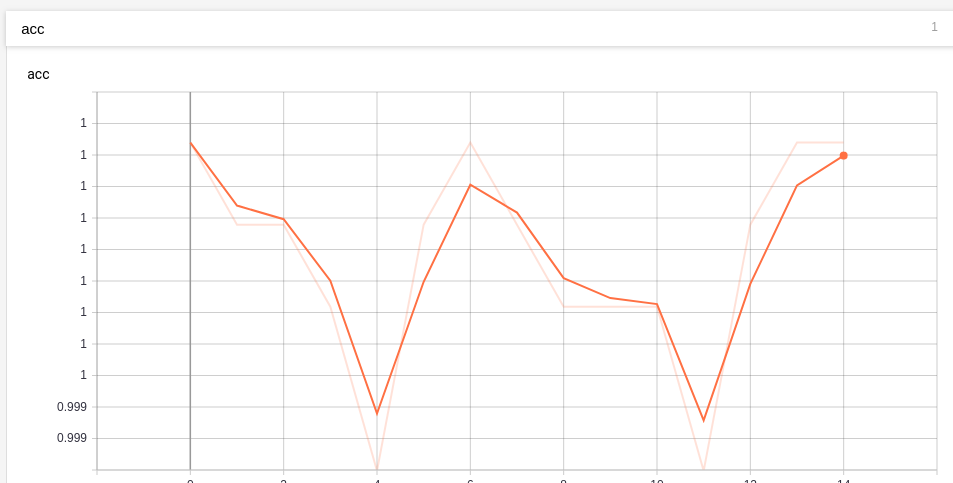

#### Train Loss

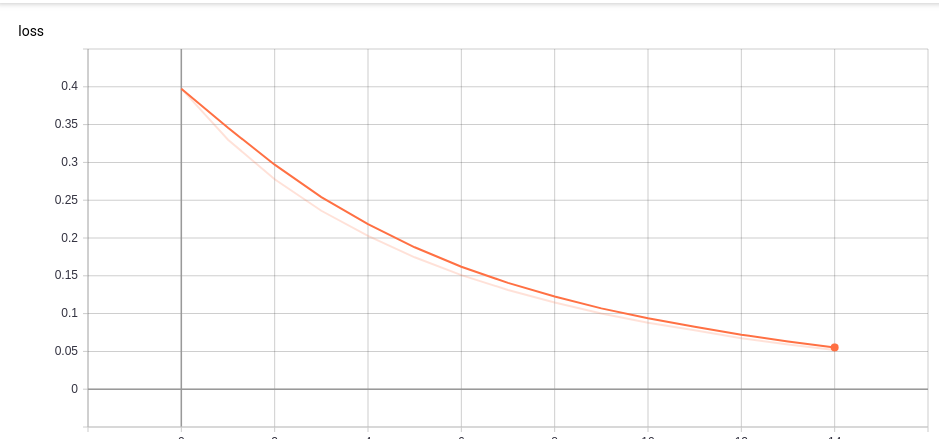

#### Validation Accuracy

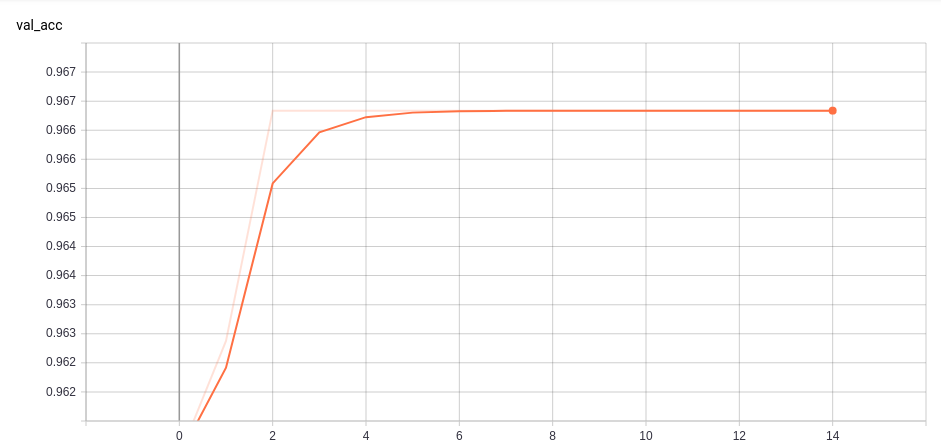

#### Validation Loss

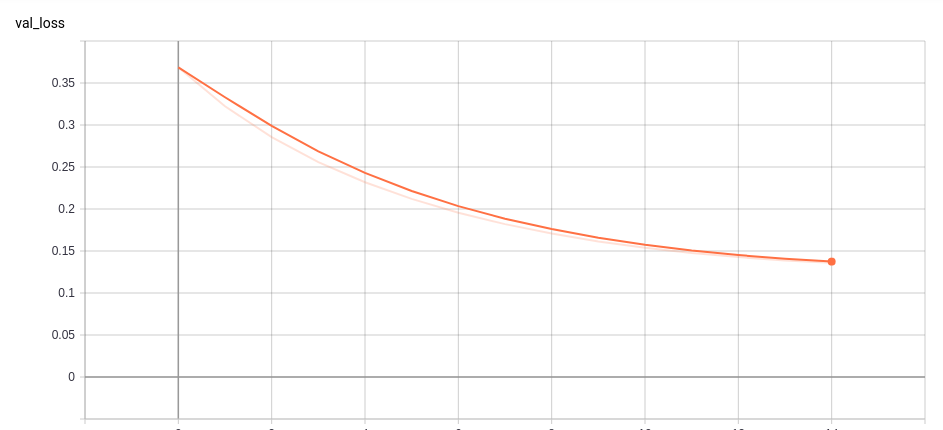

### Weights histogram plot for only TOP dense layer

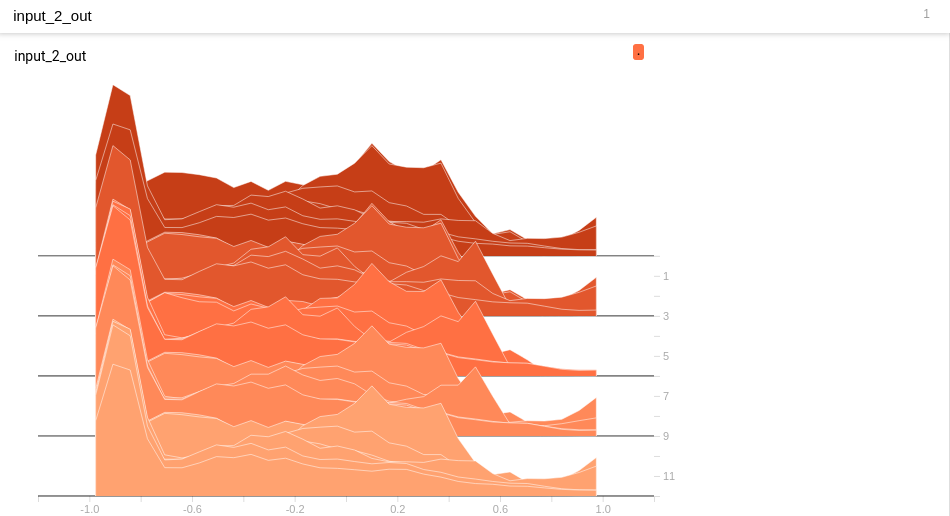

In [10]:
model_finetune1.save("model_finetuned_xception.hdf5")

In [11]:
model_finetune1.evaluate(x_train,Y_train)

7676/7676 [==============================] - 1700s 222ms/step


[0.0883356871752145, 1.0]

In [ ]:
model_finetune1.evaluate(x_cv,Y_cv)

224/505 [============>.................] - ETA: 1:02

In [ ]:
#Unseen data
model_finetune1.evaluate(x_test,Y_test)